# **offsprings_finder**


 Python script to find possible offspring barcodes (barcodes generated due to errors in PCR reactions/sequencing reaction).
 This script finds barcodes that have only one or two different nucleotides with respect to other barcodes with a higher frequency.

For additional details, please refer to the GitHub repository: https://github.com/RTlabCBM/FidelityFinder

In [ ]:
#@markdown # Upload your json file with the barcodes found and their frequency

#@markdown  Input file must be a JSON file containing barcodes as keys and their corresponding frequencies as values.
#@markdown  All barcodes are expected to have the same length. If they do not, they can be filtered using the provided barcode_length parameter.
#@markdown  JSON content example:
#@markdown
#@markdown {"CGGTCTGACAACTA": 4, "ACAAACTTTTATCA": 5, "TGAATCTGGTACTA": 8}

from google.colab import files
uploaded = files.upload()
input_file=list(uploaded.keys())[0]

Saving test4_barcodes.json to test4_barcodes.json


In [ ]:
#@markdown # Input parameters
output_prefix = "my_sample" #@param {type:"string"}
barcode_length = 14 #@param {type:"number"}

	Step 1 => Parameters catching
	Step 1 done

	Step 2 => Open & read input file
	Step 2 done

	Step 2.2 => Filtering right barcodes sizes
	Step 2.2 done

	Step 3 => Finding offspring barcodes


100%|██████████| 65/65 [00:00<00:00, 13550.19it/s]

		Total barcodes:  65
		Barcodes with 1 difference from other barcodes with higher frequency:  29
		Barcodes with 2 differences from other barcodes with higher frequency:  10
	Step 3 done

	Step 4 => Calculating number of occurrences for offspring barcodes frequencies 
		Occurrences of each frequency for all barcodes:  {1: 37, 2: 4, 3: 1, 4: 1, 5: 2, 6: 1, 12: 1, 14: 1, 16: 1, 18: 1, 21: 1, 37: 1, 39: 1, 53: 1, 59: 1, 68: 1, 94: 1, 99: 1, 102: 2, 103: 1, 112: 1, 123: 1, 217: 1, 313: 1}
		Occurrences of each frequency for barcodes with 1 difference from other barcodes with higher frequency:  {1: 23, 2: 4, 3: 1, 5: 1}
		Occurrences of each frequency for barcodes with 2 differences from other barcodes with higher frequency:  {1: 10}
	Step 4 done

	Step 5 => Plotting frequencies of barcodes with 1 or 2 differences from other barcodes with equal or higher frequency


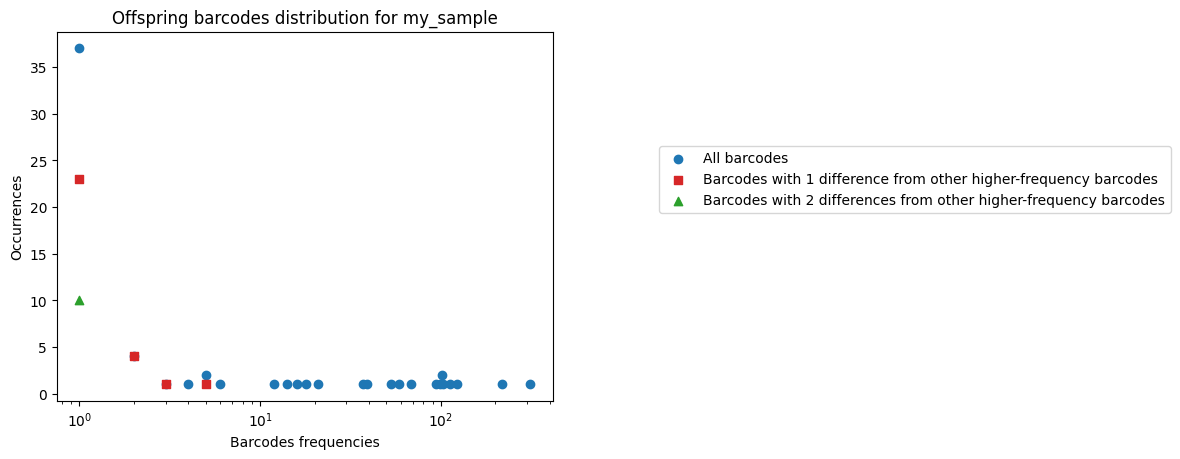

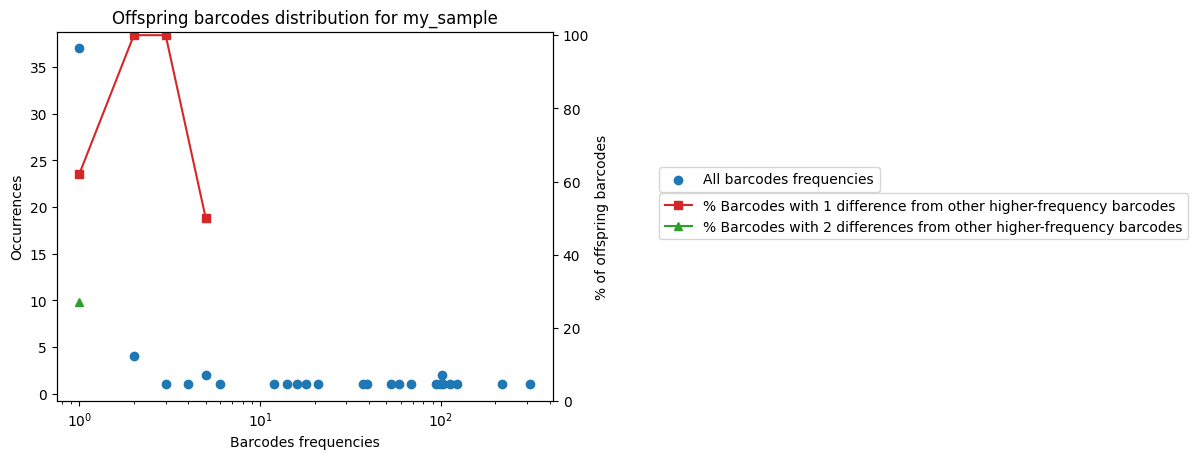

	Step 5 done



######################  END  ######################


In [ ]:
#@markdown # Main program
__file__ = "main_program"

# encoding:UTF-8



########################################################################################

__doc__ = """
SYNOPSIS

 Python script to find possible offspring barcodes (barcodes generated due to errors in PCR reactions/sequencing reaction).
 This script finds barcodes that have only one or two different nucleotides with respect to other barcodes with a higher frequency.

 This script is an adaptation of the original program to be run on Google Colab.

DESCRIPTION

 Parameters. These variables are needed:

    input_file		      file
    output_prefix		    output prefix
    barcode_length	    length of the barcodes


 Input file:
 Input file must be a JSON file containing barcodes as keys and their corresponding frequencies as values.
 All barcodes are expected to have the same length. If they do not, they can be filtered using the provided barcode_length parameter.
 JSON content example:
    {"ATGTGCT": 4, "ATGTGTA": 2, ...}

AUTHORS

    Javier Martinez del Río (javier.martinez@cbm.csic.es; javier.mardelrio@gmail.com)

"""

__version__ = 'v1.0.0'


## Imports
##----------

import sys, os
import json
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline
from tqdm import tqdm




## Functions
##----------

def send_error_message(message):
    """Gives an error message"""
    print("\n\t########## ERROR ########## \n{}\n".format(message))
    sys.exit(1)

def filter_barcodes_by_length(barcodes_dic, barcode_length):
    """
    Filter barcodes in the given dictionary by length.

    Parameters:
        barcodes_dic (dict): Dictionary where keys are barcodes and values are their frequencies.
        barcode_length (int): Desired length for the barcodes.

    Returns:
        dict: Filtered dictionary containing only barcodes with the specified length.
    """
    try:
        filtered_barcodes_dic = {}
        for barcode, frequency in barcodes_dic.items():
            if len(barcode) == barcode_length:
                filtered_barcodes_dic[barcode] = frequency
        return filtered_barcodes_dic
    except Exception as error:
        send_error_message(f'It was not possible to filter the right barcode lengths. Error: \n{error}')

def find_offspring_barcodes(barcodes_dic):
    """
    Identify potential offspring barcodes based on nucleotide differences with higher-frequency barcodes.

    Parameters:
        barcodes_dic (dict): Dictionary containing barcodes as keys and their corresponding frequencies as values.

    Returns:
        tuple: A tuple containing two dictionaries:
            - offsprings_1differenc_dic (dict): Barcodes with 1 difference from other higher-frequency barcodes
            - offsprings_2differenc_dic (dict): Barcodes with 2 differences from other higher-frequency barcodes
    """

    offsprings_1differenc_dic = defaultdict(int)
    offsprings_2differenc_dic = defaultdict(int)
    # Iterate over all barcode sequences in the list
    for barcode1, barcode1_freq in tqdm(barcodes_dic.items()):
        for barcode2, barcode2_freq in barcodes_dic.items():
            if barcode1_freq < barcode2_freq:
                # Count nucleotide differences between barcode sequences barcode1 and barcode2, ignoring case
                differences_count = sum(1 for nt1, nt2 in zip(barcode1.lower(), barcode2.lower()) if nt1 != nt2)
                # If we find 1 or 2 differences, we consider that barcode1 is an offspring of barcode2
                if differences_count == 1:
                    offsprings_1differenc_dic[barcode1] = barcode1_freq
                elif differences_count == 2:
                    offsprings_2differenc_dic[barcode1] = barcode1_freq
    # Print summary statistics
    print("\t\tTotal barcodes: ", len(barcodes_dic))
    print("\t\tBarcodes with 1 difference from other barcodes with higher frequency: ", len(offsprings_1differenc_dic))
    print("\t\tBarcodes with 2 differences from other barcodes with higher frequency: ", len(offsprings_2differenc_dic))
    return offsprings_1differenc_dic, offsprings_2differenc_dic

def calculate_frequency_of_frequencies(barcodes_dic):
    """
    Calculate the frequencies of frequencies in the given dictionary.

    Parameters:
        barcodes_dic (dict): Dictionary containing barcodes as keys and their corresponding frequencies as values.

    Returns:
        sorted_result_dict (dict): A dictionary where keys are frequencies and values are the count of occurrences of each frequency.
    """
    frequencies = list(barcodes_dic.values())
    frequency_counter = Counter(frequencies)
    sorted_result_dict = dict(sorted(frequency_counter.items()))
    return sorted_result_dict

def plot_frequencies_graph(counted_barcodes_frequencies_dic, counted_offsprings_1differenc_frequencies_dic, counted_offsprings_2differenc_frequencies_dic, output_prefix):
    """
    Plot the frequencies of frequencies for three datasets using a scatter plot.

    Parameters:
        counted_barcodes_frequencies_dic, counted_offsprings_1differenc_frequencies_dic, counted_offsprings_2differenc_frequencies_dic (dict): Dictionaries where keys are frequencies
                                                                                                                                               and values are the count of occurrences of each frequency.
                                                                                                                                               Dictionaries are assumed to be sorted by frequencies in ascending order.
        output_prefix (str): Output prefix for the plot file.
    """
    plot_file  = output_prefix + "_differences.png"

    # Extract frequencies and occurrences for each dataset
    frequencies1, occurrences1 = list(counted_barcodes_frequencies_dic.keys()), list(counted_barcodes_frequencies_dic.values())
    frequencies2, occurrences2 = list(counted_offsprings_1differenc_frequencies_dic.keys()), list(counted_offsprings_1differenc_frequencies_dic.values())
    frequencies3, occurrences3 = list(counted_offsprings_2differenc_frequencies_dic.keys()), list(counted_offsprings_2differenc_frequencies_dic.values())

    # Create a scatter plot for each dataset
    plt.scatter(frequencies1, occurrences1, color='tab:blue', label='All barcodes', marker='o')
    plt.scatter(frequencies2, occurrences2, color='tab:red', label='Barcodes with 1 difference from other higher-frequency barcodes', marker='s')
    plt.scatter(frequencies3, occurrences3, color='tab:green', label='Barcodes with 2 differences from other higher-frequency barcodes', marker='^')

    # Add labels and title
    plt.xlabel('Barcodes frequencies')
    plt.ylabel('Occurrences')
    plt.title('Offspring barcodes distribution for ' + output_prefix)

    # Set x-axis to log scale
    plt.xscale('log')

    # Add legend
    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.6))

    # Save the plot to the file specified by plot_file
    plt.savefig(plot_file, bbox_inches='tight')
    plt.show()
    plt.close()
    return plot_file

def plot_frequencies_percentages_graph(counted_barcodes_frequencies_dic, counted_offsprings_1differenc_frequencies_dic, counted_offsprings_2differenc_frequencies_dic, output_prefix):
    """
    Plot the frequencies of frequencies for the counted_barcodes_frequencies_dic and the percentage of counted frequencies for counted_offsprings_1differenc_frequencies_dic and counted_offsprings_2differenc_frequencies_dic

    Parameters:
        counted_barcodes_frequencies_dic, counted_offsprings_1differenc_frequencies_dic, counted_offsprings_2differenc_frequencies_dic (dict): Dictionaries where keys are frequencies
                                                                                                                                               and values are the count of occurrences of each frequency.
                                                                                                                                               Dictionaries are assumed to be sorted by frequencies in ascending order.
        output_prefix (str): Output prefix for the plot file.
    """
    plot_file_percentages  = output_prefix + "_percentage_differences.png"

    # Extract frequencies and occurrences/percentages for each dataset
    frequencies1, occurrences1 = list(counted_barcodes_frequencies_dic.keys()), list(counted_barcodes_frequencies_dic.values())

    percentage_offsprings_1differenc_frequencies_dic = {frequence: occurrence / counted_barcodes_frequencies_dic[frequence] * 100 for frequence, occurrence in counted_offsprings_1differenc_frequencies_dic.items()}
    frequencies2, percentages2 = list(percentage_offsprings_1differenc_frequencies_dic.keys()), list(percentage_offsprings_1differenc_frequencies_dic.values())

    percentage_offsprings_2differenc_frequencies_dic = {frequence: occurrence / counted_barcodes_frequencies_dic[frequence] * 100 for frequence, occurrence in counted_offsprings_2differenc_frequencies_dic.items()}
    frequencies3, percentages3 = list(percentage_offsprings_2differenc_frequencies_dic.keys()), list(percentage_offsprings_2differenc_frequencies_dic.values())

    # Create a scatter plot
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax2.set_ylim(0, 101)
    ax.scatter(frequencies1, occurrences1, color='tab:blue', label='All barcodes frequencies', marker='o')
    ax2.plot(frequencies2, percentages2, 's-', color='tab:red', label='% Barcodes with 1 difference from other higher-frequency barcodes')
    ax2.plot(frequencies3, percentages3, '^-', color='tab:green', label='% Barcodes with 2 differences from other higher-frequency barcodes')

    # Add labels and title
    ax.set_xlabel('Barcodes frequencies')
    ax.set_ylabel('Occurrences')
    ax2.set_ylabel('% of offspring barcodes')
    ax.set_title('Offspring barcodes distribution for ' + output_prefix)

    # Set x-axis to log scale
    plt.xscale('log')

    # Add legends
    ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.6))
    ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))

    # Save the plot to the file specified by plot_file_percentages
    plt.savefig(plot_file_percentages, bbox_inches='tight')
    plt.show()
    plt.close()
    return plot_file_percentages


## Main program
##-------------



## Step 1: Parameters catching
##--------------------

print("\tStep 1 => Parameters catching")

# Check that the necessary variables have been provided
assert 'input_file' and isinstance(input_file, str), "Please provide an input JSON file"
assert 'barcode_length' and isinstance(barcode_length, (int, float)), "Please provide a valid value for 'barcode_length'"

if not os.path.isfile(input_file):
    send_error_message(f'Input file "{input_file}" of {__file__} does not exist. Please provide a valid file path.')

print("\tStep 1 done\n")



## Step 2: Open & read input file
##--------------------

print("\tStep 2 => Open & read input file")

try:
    with open(input_file, 'r') as file:
        barcodes_dic = json.load(file)
except Exception as error:
    send_error_message(f' There was an error when trying to open the input file of {__file__} for the sample {output_prefix}: \n{error}')

if len(barcodes_dic.keys()) < 1:
  send_error_message(f' No barcodes could be found, please check that the input file follows the format required and has at least one barcode')

print("\tStep 2 done\n")



## Step 2.2: Filtering right barcodes sizes
##--------------------

print("\tStep 2.2 => Filtering right barcodes sizes")

barcodes_dic = filter_barcodes_by_length(barcodes_dic, barcode_length)

if len(barcodes_dic.keys()) < 1:
  send_error_message(f'No barcodes could be found after filtering. Please ensure that "barcode_length" has the correct value.')

print("\tStep 2.2 done\n")



## Step 3: Finding offspring barcodes
##--------------------

print("\tStep 3 => Finding offspring barcodes")

try:
  offsprings_1differenc_dic, offsprings_2differenc_dic = find_offspring_barcodes(barcodes_dic)
except Exception as error:
  send_error_message(
      f'There was an error when trying to find offspring barcodes.\n'
      f'Please check that you provided a valid JSON file with the required content.\n'
      f'Input file must be a JSON file containing barcodes as keys and their corresponding frequencies as values.\n'
      f'Error found: \n{error}'
  )

print("\tStep 3 done\n")


## Step 4: Calculating number of occurrences for offspring barcodes frequencies
##--------------------

print("\tStep 4 => Calculating number of occurrences for offspring barcodes frequencies ")

counted_barcodes_frequencies_dic = calculate_frequency_of_frequencies(barcodes_dic)
counted_offsprings_1differenc_frequencies_dic = calculate_frequency_of_frequencies(offsprings_1differenc_dic)
counted_offsprings_2differenc_frequencies_dic = calculate_frequency_of_frequencies(offsprings_2differenc_dic)

print("\t\tOccurrences of each frequency for all barcodes: ", counted_barcodes_frequencies_dic)
print("\t\tOccurrences of each frequency for barcodes with 1 difference from other barcodes with higher frequency: ", counted_offsprings_1differenc_frequencies_dic)
print("\t\tOccurrences of each frequency for barcodes with 2 differences from other barcodes with higher frequency: ", counted_offsprings_2differenc_frequencies_dic)

print("\tStep 4 done\n")



## Step 5: Plotting frequencies of barcodes with 1 or 2 differences from other barcodes with equal or higher frequency
##--------------------

print("\tStep 5 => Plotting frequencies of barcodes with 1 or 2 differences from other barcodes with equal or higher frequency")

plot_file = plot_frequencies_graph(counted_barcodes_frequencies_dic, counted_offsprings_1differenc_frequencies_dic, counted_offsprings_2differenc_frequencies_dic, output_prefix)
plot_file_percentages = plot_frequencies_percentages_graph(counted_barcodes_frequencies_dic, counted_offsprings_1differenc_frequencies_dic, counted_offsprings_2differenc_frequencies_dic, output_prefix)

print("\tStep 5 done\n")


print("\n")
print("######################  END  ######################")





In [ ]:
#@markdown # Download files
files.download(plot_file)
files.download(plot_file_percentages)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>